## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
# ML imports
import torch
from torch.nn import CrossEntropyLoss
from torchvision import transforms

from avalanche.models import SimpleMLP, SimpleCNN
#from avalanche.training import Naive
from avalanche.benchmarks.classic import PermutedMNIST #,PermutedOmniglot, RotatedOmniglot

from matplotlib import pyplot as plt

# Local imports
import models
import utils

In [3]:
# Config
device = utils.get_device()

# model
model = SimpleMLP(input_size=784, hidden_layers=3, num_classes=10)
model = SimpleCNN(num_classes=10)

# CL Benchmark Creation
# Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
transform = transforms.Compose([
    #transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

# SimpleMLP
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))])

# SimpleCNN
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

perm_mnist = PermutedMNIST(n_experiences=3, train_transform=transform, eval_transform=transform)
train_stream = perm_mnist.train_stream
test_stream = perm_mnist.test_stream

# Prepare for training & testing
criterion = CrossEntropyLoss()

# Continual learning strategy
#cl_strategy = models.LatentReplay(criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, device=device) 
latent_layer_number = 7

cl_strategy = models.AR1(
    model=model, 
    criterion=criterion, 
    train_mb_size=32, 
    train_epochs=2, 
    eval_mb_size=32, 
    latent_layer_num=latent_layer_number, 
    freeze_below_layer=f"lat_features.{latent_layer_number}", 
    device=device
    )

# train and test loop over the stream of experiences
results = []

for train_exp in train_stream:
    cl_strategy.train(train_exp)
    results.append(cl_strategy.eval(test_stream))

MobilenetV1(
  (lat_features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (end_features): Sequential(
    (0): ReLU(inplace=True)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): AdaptiveMaxPool2d(output_size=1)
    (8): Dropout(p=0.25, inplace=False)
  )
  (output): Linear(in_features=64, out_features=10, bias=False)
)
-- >> Start of training phase << --
100%|██████████| 1875

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

[{'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.4832666666666667, 'Loss_Epoch/train_phase/train_stream/Task000': 1.5653703022956849, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.8489, 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.5556901431560516, 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.0924, 'Loss_Exp/eval_phase/test_stream/Task001/Exp001': 2.4419409854888916, 'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.8489, 'Top1_Acc_Stream/eval_phase/test_stream/Task001': 0.0924, 'Loss_Stream/eval_phase/test_stream/Task000': 0.5556901431560516, 'Loss_Stream/eval_phase/test_stream/Task001': 2.4419409854888916}, {'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.4832666666666667, 'Loss_Epoch/train_phase/train_stream/Task000': 1.5653703022956849, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.7841, 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.7441683361053467, 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.8074, 'Loss_Exp/eval

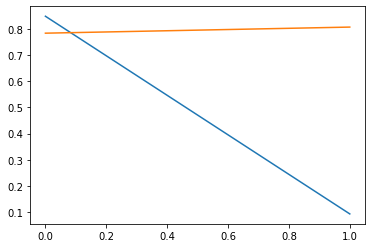

In [ ]:
# JA: Next step - replace internal model.
# - model def
# - frozen layer name
# - batch renorm stuff...?

# JA: 2nd step
# - make GMM
# - add GMM to model sampler

results_ar1 = results
print(results_ar1)

['Top1_Acc_Epoch/train_phase/train_stream/Task000', 
 'Loss_Epoch/train_phase/train_stream/Task000',
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000',
 'Loss_Exp/eval_phase/test_stream/Task000/Exp000',
 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001',
 'Loss_Exp/eval_phase/test_stream/Task001/Exp001',
 'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002',
 'Loss_Exp/eval_phase/test_stream/Task002/Exp002',
 'Top1_Acc_Stream/eval_phase/test_stream/Task000',
 'Top1_Acc_Stream/eval_phase/test_stream/Task001',
 'Top1_Acc_Stream/eval_phase/test_stream/Task002',
 'Loss_Stream/eval_phase/test_stream/Task000',
 'Loss_Stream/eval_phase/test_stream/Task001',
 'Loss_Stream/eval_phase/test_stream/Task002',
 'Top1_Acc_Epoch/train_phase/train_stream/Task001',
 'Loss_Epoch/train_phase/train_stream/Task001',
 'Top1_Acc_Epoch/train_phase/train_stream/Task002',
 'Loss_Epoch/train_phase/train_stream/Task002']

def plotplot(results):
    results_clean = {"train":{'acc':[], 'loss':[]}, "test":{'acc':[], 'loss':[]}}
    loss_prefix = 'Loss_Stream/eval_phase/test_stream/'
    acc_prefix = 'Top1_Acc_Stream/eval_phase/test_stream/'
    
    for result in results:
        results_clean["test"]['loss'].append([
            result[f'{loss_prefix}Task000'], 
            result[f'{loss_prefix}Task001'], 
            result[f'{loss_prefix}Task002']])
        
        results_clean["test"]['acc'].append([
            result[f'{acc_prefix}Task000'], 
            result[f'{acc_prefix}Task001'], 
            result[f'{acc_prefix}Task002']])
        
        results_clean["train"]['loss'].append([
            result['Loss_Epoch/train_phase/train_stream/Task000'], 
            result['Loss_Epoch/train_phase/train_stream/Task001'], 
            result['Loss_Epoch/train_phase/train_stream/Task002']])
    
    return results_clean
        
results_ar1_clean = plotplot(results)
results_ar1_clean

plt.plot(list(zip(*results_ar1_clean["test"]['loss'])), label=['task1','task2','task3'])
